# 02. Simple parameter estimation

This notebook demonstrates how to run a simple parameter estimation by fitting a model to experimental data. It provides an introduction to the `Estimator` class which collects user inputs and manages estimation tasks. Further we introduce the optimization algorithms that are currently featured in `estim8`.

## Imports

In [3]:
import sys 
sys.path.append(r'..')

from estim8.models import FmuModel
from estim8 import visualization, datatypes, Estimator
import pandas as pd

## Model import
To load a FMU model, we pass it's path to the `FmuModel` class. For more information about this class we refer to [Notebook 1](1.%20Modeling%20&%20Simulation.ipynb)

In [4]:
# load and init model
SimpleBatchModel = FmuModel(path=r'SimpleBatch.fmu')
# simulate with default parameters
simulation = SimpleBatchModel.simulate(t0=0, t_end=10, stepsize=0.001)

# print observable states and variables of the model
SimpleBatchModel.observables

['S', 'X', 'der(S)', 'der(X)', 'mu']

## Loading experimental data
In this example, we import the raw experimental data from an Excel-Sheet using `pandas`. This artificial data contains measurements of biomass concentration `X` and substrate concentration `S` over the course of a batch fermentation.


In [5]:
# import datasheet
data = pd.read_excel(r'SimpleBatch_Data.xlsx', index_col=0)
data.head(11)

,X,S
0.0,0.176200,NaN
0.1,0.318313,NaN
0.2,0.285270,NaN
0.3,0.218600,NaN
0.4,0.248210,NaN
0.5,0.268477,NaN
0.6,0.312500,NaN
0.7,0.150687,NaN
0.8,0.226870,NaN
0.9,0.258150,NaN


## Data structure setup

Next, we create an `Experiment` object. For convenience, it is possible to directly pass the `pandas.DataFrame` we just created, and no observation mapping is required, as the name of the measurements in `data` match the names `X`and `S` in the models observables. For a more detailed intrrduction, advanced features for data management and creation of `Experiment` objects have a look at [Notebook 3](3.%20Experimental%20data%20and%20error%20modeling.ipynb). 

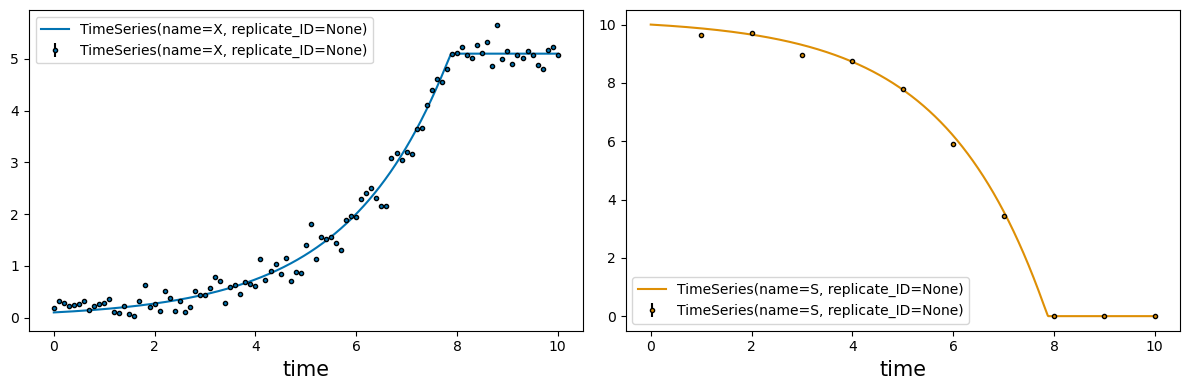

In [6]:
# create an Experiment object
experiment = datatypes.Experiment(data)


# compare simulation to data
_ = visualization.plot_simulation(simulation=simulation, experiment=experiment, observe=[ 'X',  'S'])

## Deining the estimation problem

Paramaters to be estimated are defined in a dictionary containing their upper and lower bounds:

In [7]:
bounds = {
    'X0': [0.05, 0.15],
    'mu_max': [0.1, 0.9],
    'Y_XS': [0.1, 1]
    # 'Y_XS': None
}

## The `Estimator` class

The `Estimator` class combines all the user input and manages the processes of model fitting. To create an instance

| Argument  | Type | Description |
| --------  | ---- | ----------- |
| model     | models.Estim8Model | The model class used for parameter fitting. Must be a subclass of Estim8Model that runs the simulations. |
| bounds    | dict | The unkown parameters with their bounds |
|  

In [8]:
# Instantiating an Estimator object
estimator = Estimator(
    model=SimpleBatchModel,
    bounds=bounds,        # anknowns and bounds
    data=experiment,      # experimental data
    t=[0, 10, 0.1],        # the timeframe for simulation,
    metric = 'SS'         # default Sum of squared residuals
)

## Optimization Algortithms
`Estim8` supports a variety of optimzation algorithms from [scipy.optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html), [scikit-optimize](https://scikit-optimize.github.io/stable/) and [pygmo](https://esa.github.io/pygmo2/index.html). Is is higly recommended to check out their documentations, e.g. for the use of solver hyperparameters. 

###  scipy and scikit-optimize alogorithms and keys: 

| method key         | optimization function          | solver parallelization |
|-----------------|-----------------------------------|------------------------|
| local           | `scipy.optimize.minimize`         | ❌                  |
| de              | `scipy.optimize.differential_evolution` | ✅               |
| bh              | `scipy.optimize.basinhopping`     |❌                  |
| shgo            | `scipy.optimize.shgo`             |✅               |
| dual_annealing  | `scipy.optimize.dual_annealing`   |❌                  |
| gp              | `skopt.gp_minimize`               |✅               |



### Single core parameter estimation
Single core estimation supports all optimization functions from scipy and scikit-optimize listed above.

In [9]:
estimates, info = estimator.estimate(
    method='de',
    max_iter=1000,          # maximum number of iterations for the solver
    optimizer_kwargs={      # kewyword arguments to pass to the optimization function
        'disp': True
    }
)

differential_evolution step 1: f(x)= 50.827003016570856
differential_evolution step 2: f(x)= 9.945552792335342
differential_evolution step 3: f(x)= 9.945552792335342
differential_evolution step 4: f(x)= 4.854841188969323
differential_evolution step 5: f(x)= 4.854841188969323
differential_evolution step 6: f(x)= 4.068109714712882
differential_evolution step 7: f(x)= 3.8628414671887494
differential_evolution step 8: f(x)= 3.8628414671887494
differential_evolution step 9: f(x)= 3.8568248439083623
differential_evolution step 10: f(x)= 3.8568248439083623
differential_evolution step 11: f(x)= 3.8568248439083623
differential_evolution step 12: f(x)= 3.856261247620308
differential_evolution step 13: f(x)= 3.856261247620308
differential_evolution step 14: f(x)= 3.8515479052966555
differential_evolution step 15: f(x)= 3.8506109539585602
differential_evolution step 16: f(x)= 3.8506109539585602
differential_evolution step 17: f(x)= 3.8506109539585602
differential_evolution step 18: f(x)= 3.8506109

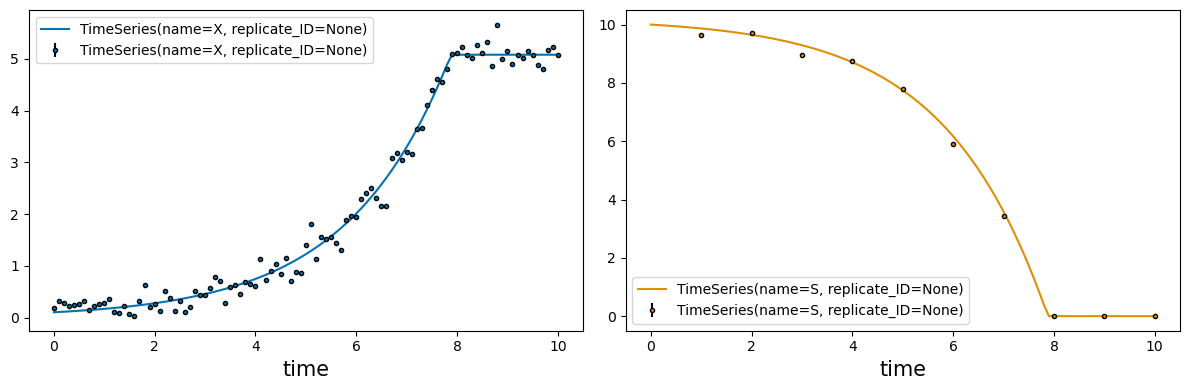

In [10]:
# compare fitted model to data
_ = visualization.plot_estimates(estimates=estimates, estimator=estimator, only_measured=True)

### Multicore parameter estimation


In [11]:
estimates, info = estimator.estimate(
    method='de',
    max_iter=1000,          # maximum number of iterations for the solver,
    n_jobs = 4,             # process pool size of the solver algorithm
    optimizer_kwargs={      # kewyword arguments to pass to the optimization function
        'disp': True
    }
)

c:\Users\Latour\AppData\Local\miniforge-pypy3\envs\testim8\lib\site-packages\scipy\optimize\_differentialevolution.py:486: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


differential_evolution step 1: f(x)= 9.113581238391259
differential_evolution step 2: f(x)= 9.113581238391259
differential_evolution step 3: f(x)= 4.034148379186327
differential_evolution step 4: f(x)= 4.034148379186327
differential_evolution step 5: f(x)= 4.034148379186327
differential_evolution step 6: f(x)= 4.034148379186327
differential_evolution step 7: f(x)= 4.034148379186327
differential_evolution step 8: f(x)= 4.034148379186327
differential_evolution step 9: f(x)= 4.034148379186327
differential_evolution step 10: f(x)= 3.972759913487292
differential_evolution step 11: f(x)= 3.972759913487292
differential_evolution step 12: f(x)= 3.9280831008387356
differential_evolution step 13: f(x)= 3.857185155022042
differential_evolution step 14: f(x)= 3.857185155022042
differential_evolution step 15: f(x)= 3.855768068315711
differential_evolution step 16: f(x)= 3.855768068315711
differential_evolution step 17: f(x)= 3.855768068315711
differential_evolution step 18: f(x)= 3.854298353986614


### pygmo

| method key                | algorithm                                         |
|------------------------|-----------------------------------------------------|
| scipy_optimize          | A wrapper around `scipy.optimize.minimize`          |
| de1220                 | Self-adaptive Differential Evolution, pygmo flavour (pDE) |
| bee_colony             | Artificial Bee Colony                               |
| gaco                   | Extended Ant Colony Optimization algorithm          |
| pso                    | Particle Swarm Optimization                         |
| sga                    | A Simple Genetic Algorithm                          |
| sea                    | (N+1)-ES simple evolutionary algorithm              |
| compass_search          | Compass Search                                      |
| gwo                    | Grey Wolf Optimizer (gwo)                           |
| cmaes                  | Covariance Matrix Evolutionary Strategy (CMA-ES)     |
| simulated_annealing     | Simulated Annealing (Corana’s version)              |
| nsga2                  | Non dominated Sorting Genetic Algorithm (NSGA-II)    |
| mbh                    | Monotonic Basin Hopping (generalized)               |
| ihs                    | Improved harmony search algorithm                   |
| xnes                   | Exponential Evolution Strategies                    |
| de                     | Differential Evolution                              |

For using `pygmo`'s Generalized Islands approach, pass a list of the solver algorithms. 

In [12]:
estimates, info = estimator.estimate(
    method=['sga']*4,       # algorithms for islands
    n_jobs=4,               # process pool size of the solver algorithm
    max_iter=1,             # iterations
    optimizer_kwargs = {
        'n_evos': 10,       # evolutions per iteration, total evos = n_evos * max_iter
        'pop_size': 30,
    }
)

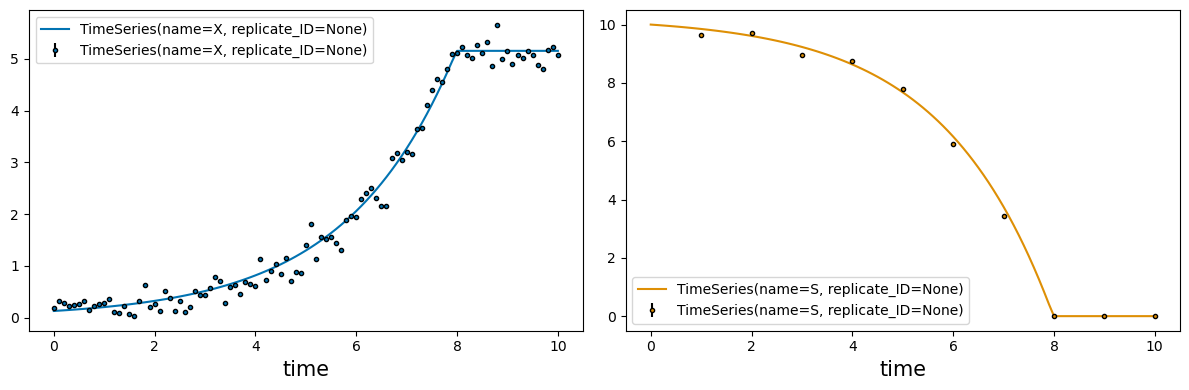

In [13]:
# compare fitted model to data
_ = visualization.plot_estimates(estimates=estimates, estimator=estimator, only_measured=True)

In [14]:
estimates, info = estimator.estimate(
    method=['pso']*2,       # algorithms for islands
    n_jobs=4,               # process pool size of the solver algorithm
    max_iter=1,             # iterations
    optimizer_kwargs = {
        'n_evos': 10,       # evolutions per iteration, total evos = n_evos * max_iter
        'pop_size': 30,
    }
)

In [16]:
estimates, info = estimator.estimate(
    method=['pso']*2,       # algorithms for islands
    n_jobs=4,               # process pool size of the solver algorithm
    max_iter=1,             # iterations
    optimizer_kwargs = {
        'n_evos': 40,       # evolutions per iteration, total evos = n_evos * max_iter
        'pop_size': 30,
        "report": True
    }
)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    7.4s finished


>>> Created Island 1 using <pygmo.core.pso object at 0x0000025699384430>
>>> Created Island 2 using <pygmo.core.pso object at 0x0000025699384EB0>


2025-01-27 12:46:43,973 - estim8.generalized_islands - INFO - ## Evolution 1 of island 2570959175840 completed:
      Algorithm: PSO: Particle Swarm Optimization
      Champion loss: 5.16e+00
2025-01-27 12:46:44,009 - estim8.generalized_islands - INFO - ## Evolution 1 of island 2570959181264 completed:
      Algorithm: PSO: Particle Swarm Optimization
      Champion loss: 4.81e+00
2025-01-27 12:46:53,050 - estim8.generalized_islands - INFO - ## Evolution 2 of island 2570959175840 completed:
      Algorithm: PSO: Particle Swarm Optimization
      Champion loss: 4.35e+00
2025-01-27 12:46:53,058 - estim8.generalized_islands - INFO - ## Evolution 2 of island 2570959181264 completed:
      Algorithm: PSO: Particle Swarm Optimization
      Champion loss: 4.08e+00
2025-01-27 12:46:55,713 - estim8.generalized_islands - INFO - ## Evolution 3 of island 2570959181264 completed:
      Algorithm: PSO: Particle Swarm Optimization
      Champion loss: 4.08e+00
2025-01-27 12:46:55,735 - estim8.general

In [1]:
import pickle


In [3]:
with open("..\marijke\error_29552", "rb") as f:
    error = pickle.load(f)

EOFError: Ran out of input